In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

In [3]:
DATASET_DIR = "/content/drive/MyDrive/Datasets/Skin Cancer with Categories/Skin cancer ISIC/Train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 9

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [5]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2)
])

In [8]:
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),       # reemplaza Flatten
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [11]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stop]
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 520s 9s/step - accuracy: 0.1753 - loss: 2.3290 - val_accuracy: 0.2058 - val_loss: 2.0611 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.2003 - loss: 2.0450 - val_accuracy: 0.2058 - val_loss: 2.0422 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - accuracy: 0.2177 - loss: 2.0135 - val_accuracy: 0.2058 - val_loss: 2.0631 - learning_rate: 0.0010
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.1926 - loss: 2.0244 - val_accuracy: 0.1432 - val_loss: 2.0514 - learning_rate: 0.0010
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.1929 - loss: 2.0203
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step - accuracy: 0.1928 - loss: 2.0205 - val_accuracy: 0.2058 - val_loss: 2.0470 - learning_rate: 0.0010
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.2145 - loss: 2.0044

In [14]:
save_path = "/content/drive/MyDrive/skin-cancer/saved_models/isic_multiclass_cnn_v2.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)
print(f"✅ Modelo guardado correctamente en: {save_path}")

✅ Modelo guardado correctamente en: /content/drive/MyDrive/skin-cancer/saved_models/isic_multiclass_cnn_v2.keras


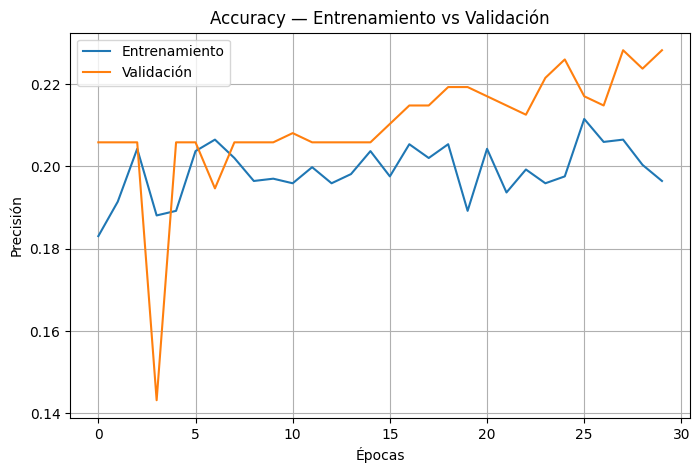

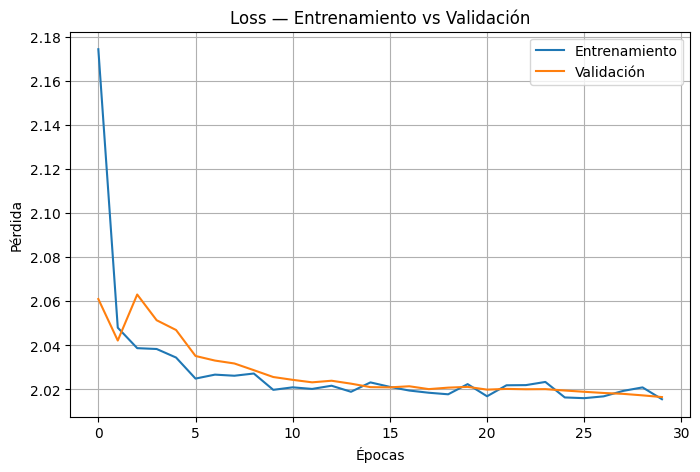

In [15]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Accuracy — Entrenamiento vs Validación")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Loss — Entrenamiento vs Validación")
plt.legend()
plt.grid(True)
plt.show()